In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D


print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.6.2


In [2]:
base_dir = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

Working Directory Contents: ['MildDemented', 'ModerateDemented', 'VeryMildDemented', 'NonDemented']


In [3]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


In [4]:
train_data, train_labels = next(train_data_gen)
train_data.shape, train_labels.shape

((6400, 176, 176, 3), (6400, 4))

In [5]:
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


In [6]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, valid_data, train_labels, valid_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [7]:
inception_model = InceptionV3(input_shape=(176, 176, 3), include_top=False, weights="imagenet")

2022-04-11 15:10:58.354592: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 15:10:58.469236: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 15:10:58.470220: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-11 15:10:58.471963: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

87924736/87910968 [==============================] - 1s 0us/step


In [8]:
for layer in inception_model.layers:
    layer.trainable=False

In [9]:
model = Sequential([
        inception_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ], name = "InceptionV3")

In [10]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

In [11]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=4),
           tf.keras.metrics.Recall(name='recall')]

CALLBACKS = [my_callback, rop_callback]
    
model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

model.summary()

Model: "InceptionV3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 4, 4, 2048)        21802784  
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization_94 (Batc (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
batch_normalization_95 (Batc (None, 512)               

In [12]:
%%time
#Fit the training data to the model and validate it using the validation data
EPOCHS = 50

history = model.fit(train_data, train_labels, validation_data=(valid_data, valid_labels), callbacks=CALLBACKS, epochs=EPOCHS)

2022-04-11 15:11:05.660995: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3045064704 exceeds 10% of free system memory.
2022-04-11 15:11:08.674838: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3045064704 exceeds 10% of free system memory.
2022-04-11 15:11:11.272602: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-04-11 15:11:19.794086: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


256/256 [==============================] - ETA: 0s - loss: 1.3508 - acc: 0.4142 - auc: 0.6919 - f1_score: 0.4109 - recall: 0.2761

2022-04-11 15:11:37.105309: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 761266176 exceeds 10% of free system memory.
2022-04-11 15:11:37.889793: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 761266176 exceeds 10% of free system memory.


256/256 [==============================] - 32s 69ms/step - loss: 1.3508 - acc: 0.4142 - auc: 0.6919 - f1_score: 0.4109 - recall: 0.2761 - val_loss: 0.8039 - val_acc: 0.6299 - val_auc: 0.8835 - val_f1_score: 0.6243 - val_recall: 0.3408
Epoch 2/50
256/256 [==============================] - 14s 54ms/step - loss: 0.9085 - acc: 0.5776 - auc: 0.8459 - f1_score: 0.5721 - recall: 0.4010 - val_loss: 0.6704 - val_acc: 0.6919 - val_auc: 0.9173 - val_f1_score: 0.6865 - val_recall: 0.4834
Epoch 3/50
256/256 [==============================] - 14s 55ms/step - loss: 0.7921 - acc: 0.6309 - auc: 0.8843 - f1_score: 0.6251 - recall: 0.4642 - val_loss: 0.6156 - val_acc: 0.7212 - val_auc: 0.9317 - val_f1_score: 0.7170 - val_recall: 0.5264
Epoch 4/50
256/256 [==============================] - 14s 56ms/step - loss: 0.7397 - acc: 0.6627 - auc: 0.9004 - f1_score: 0.6598 - recall: 0.5081 - val_loss: 0.5824 - val_acc: 0.7227 - val_auc: 0.9364 - val_f1_score: 0.7161 - val_recall: 0.5586
Epoch 5/50
256/256 [=======

In [13]:
model.save("/kaggle/working/InceptionV3", save_format = 'h5')

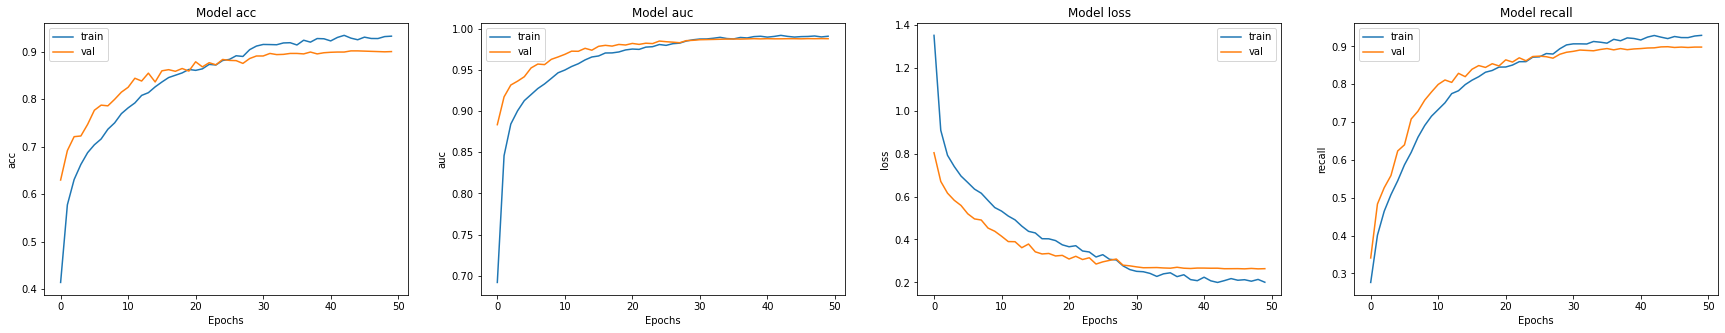

In [14]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 4, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss", "recall"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])
    
plt.savefig("/kaggle/working/InceptionResults.png", bbox_inches ="tight", dpi=600)

In [15]:
d = {
    "Accuracy": history.history["acc"],
    "AUC": history.history["auc"],
    "Loss": history.history["loss"],
    "Recall": history.history["recall"],
    "Val Accuracy": history.history["val_acc"],
    "Val AUC": history.history["val_auc"],
    "Val Loss": history.history["val_loss"],
    "Val Recall": history.history["val_recall"]    
}

df = pd.DataFrame(d)
df.to_csv("/kaggle/working/inception_results.csv", index=False)